In [2]:
#eda import
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn

In [ ]:
# csv file
benign = pd.read_csv('dataset/Benign Traffic.csv') #정상 데이터
dos_udp_flood = pd.read_csv('dataset/DoS UDP Flood.csv')
dictionary_brute_force = pd.read_csv('dataset/Dictionary Brute Force.csv')
dos_dns_flood = pd.read_csv('dataset/DoS DNS Flood.csv')
dos_icmp_flood = pd.read_csv('dataset/DoS ICMP Flood.csv')
dos_syn_flood = pd.read_csv('dataset/DoS SYN Flood.csv')
mitm_arp_spoofing = pd.read_csv('dataset/MITM ARP Spoofing.csv')
recon_host_discovery = pd.read_csv('dataset/Recon Host Discovery.csv')
recon_os_scan = pd.read_csv('dataset/Recon OS Scan.csv')
recon_ping_sweep = pd.read_csv('dataset/Recon Ping Sweep.csv')
recon_vul_scan = pd.read_csv('dataset/Recon Vulnerability Scan.csv')

In [10]:
csvs = [benign, dos_udp_flood, dictionary_brute_force, dos_dns_flood, dos_icmp_flood, dos_syn_flood, mitm_arp_spoofing, recon_host_discovery, recon_os_scan, recon_ping_sweep, recon_vul_scan]
# 각각 csv shape 확인
for csv in csvs:
    print(csv.shape)

(86525, 85)
(1848, 85)
(18151, 85)
(1702, 85)
(1405, 85)
(15243, 85)
(14768, 85)
(424, 85)
(42173, 85)
(47123, 85)
(39489, 85)


In [11]:
#각각 csv 결측값 확인
for csv in csvs:
    if csv.isnull().sum().sum() == 0:
        print('결측값 없음')

결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음
결측값 없음


In [12]:
csv.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Len

In [13]:
#Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port' 필요없는 컬럼 삭제
for csv in csvs:
    csv.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port'], axis=1, inplace=True)

In [17]:
#모든 csv 파일 합치기
df = pd.concat(csvs)
df.to_csv('dataset/total.csv', index=False)

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 [Text(0.0, 0, '0'),
  Text(20000.0, 0, '20000'),
  Text(40000.0, 0, '40000'),
  Text(60000.0, 0, '60000'),
  Text(80000.0, 0, '80000'),
  Text(100000.0, 0, '100000')])

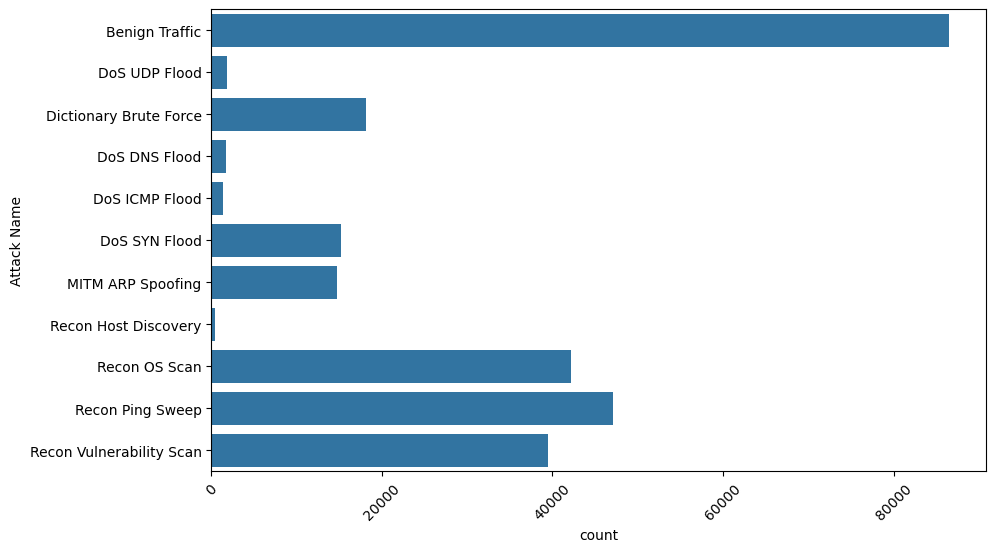

In [26]:
# attack_name 별 개수 시각화
plt.figure(figsize=(10, 6))
sns.countplot(df['Attack Name'])
plt.xticks(rotation=45)


In [27]:
#nunique값이 1인 값이 있는지 확인
df.columns[df.nunique() == 1]

Index(['Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg'],
      dtype='object')

In [28]:
df.drop(['Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg'], axis=1, inplace=True)

In [34]:
df.columns[df.nunique() <= 5]

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count',
       'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count',
       'Fwd Seg Size Min', 'Label'],
      dtype='object')